# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

In [3]:
dataset_path = "C:\\Users\\Vivek\\Udacity\\DeepLearningUsingPyTorch\\Data\\"
batch_size = 32

torch.manual_seed(42)
np.random.seed(42)

# From https://pytorch.org/vision/stable/models.html
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms
# Note to self: Try the RandomCrop or CenterCrop transforms to improve accuracy if needed
transforms_train = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(20),
                                        transforms.Resize(224), # Min size for pretrained
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)
                                     ])
transforms_test = transforms.Compose([
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                     ])

# Create training set and define training dataloader
trainset = CIFAR10(root=dataset_path, train=True, transform=transforms_train, download=True)
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
testset = CIFAR10(root=dataset_path, train=False, transform=transforms_test, download=True)
testloader = DataLoader(dataset=testset, batch_size=batch_size)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import matplotlib.pyplot as plt
import numpy as np
import os

# functions to show an image
denormalize = transforms.Compose([
                transforms.Normalize(mean=[-m/s for (m, s) in zip(mean, std)], std=[1.0/s for s in std])
])

def imshow(img):
    img = denormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

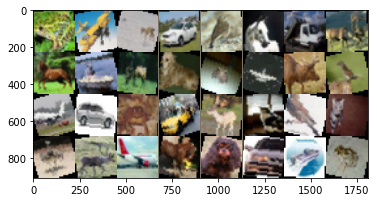


0: frog , plane, deer , car  , bird , horse, truck, deer 
1: horse, ship , deer , dog  , frog , plane, deer , bird 
2: plane, car  , frog , car  , deer , cat  , bird , cat  
3: bird , deer , plane, horse, dog  , car  , ship , frog 


In [5]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))
print(''.join(f"{str(os.linesep) + str(j//8) + ': ' if j%8 == 0 else ', '}{classes[labels[j]]:5s}" for j in range(batch_size)))

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        
        image = denormalize(images[i])
        npimg = image.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

TRAIN DATA
horse


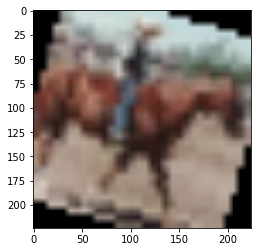

deer


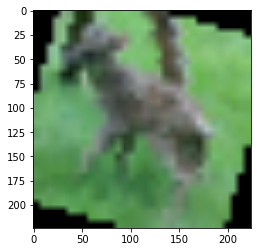

truck


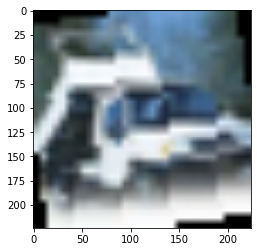

deer


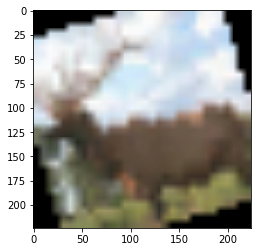

plane


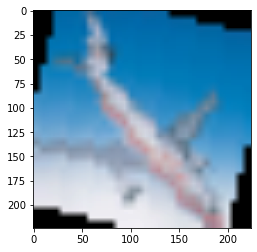

TEST DATA
cat


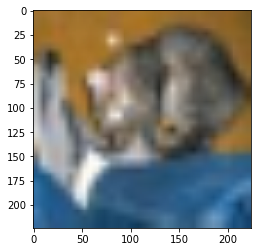

ship


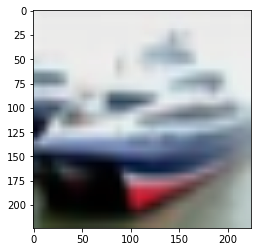

ship


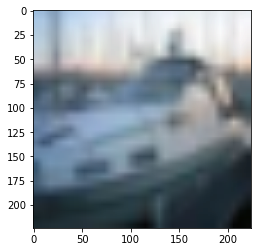

plane


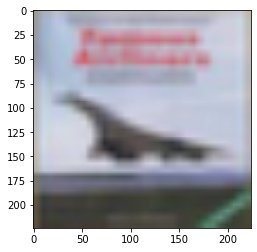

frog


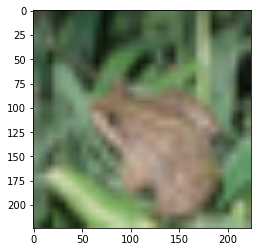

In [7]:
# Explore data
print("TRAIN DATA")
show5(trainloader)
print("TEST DATA")
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
# NOTE: I also tried to train my own model but the accuracy was not great (51.37%). 
# Code and results for that model are after the *Make a recommendation* section

model = torchvision.models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(
                nn.Linear(2048, 1024),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(512, 10),
                nn.LogSoftmax(dim=1)
             )

model.fc = classifier

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
from torch.optim import Adam
from torch.nn import NLLLoss

optimizer = Adam(params=model.fc.parameters(), lr=0.001)
criterion = NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device '{device}'")

Using device 'cuda:0'


In [11]:
EPOCHS = range(20)

per_epoch_train_loss = []
per_epoch_test_loss = []
per_epoch_accuracy = []

for epoch in EPOCHS:
    total_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
        # if batch%250 == 0:
        #    print(f"Epoch {epoch:2} Batch {batch:4} Loss: {loss:.3f} Avg Loss: {total_loss/float(batch+1):.3f}")
            
    per_epoch_train_loss.append(total_loss.item()/float(batch+1)) # Per batch loss
    
    # Compute Test Loss
    with torch.no_grad():
        model.eval()
        
        total_loss = 0
        total_correct = 0
        count = 0
        
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            log_ps = model.forward(images)
            total_loss += criterion(log_ps, labels)
            ps, pred_label = log_ps.topk(1, dim=1)
            
            total_correct += torch.sum(pred_label.view(labels.shape) == labels)
            count += len(labels)
            
        per_epoch_test_loss.append(total_loss.item() / float(batch))
        per_epoch_accuracy.append(100. * total_correct.item() / float(count))
        print(f"Epoch {epoch:2} Train Loss: {per_epoch_train_loss[-1]:.3f} Test Loss: {per_epoch_test_loss[-1]:.3f} Accuracy {per_epoch_accuracy[-1]:.2f}%")
        
        model.train()
    
    # Checkpoint at each epoch
    checkpoint_path = f"C:\\Users\\Vivek\\Udacity\\DeepLearningUsingPyTorch\\CIFAR10_classifier_checkpoints\\CIFAR10_classifier_model_epoch{epoch}.pth"
    torch.save(model.state_dict(), checkpoint_path)

Epoch  0 Train Loss: 1.178 Test Loss: 0.727 Accuracy 75.10%
Epoch  1 Train Loss: 1.020 Test Loss: 0.656 Accuracy 77.35%
Epoch  2 Train Loss: 0.981 Test Loss: 0.678 Accuracy 76.58%
Epoch  3 Train Loss: 0.961 Test Loss: 0.627 Accuracy 78.10%
Epoch  4 Train Loss: 0.949 Test Loss: 0.610 Accuracy 79.16%
Epoch  5 Train Loss: 0.922 Test Loss: 0.583 Accuracy 79.80%
Epoch  6 Train Loss: 0.923 Test Loss: 0.612 Accuracy 79.39%
Epoch  7 Train Loss: 0.911 Test Loss: 0.589 Accuracy 79.80%
Epoch  8 Train Loss: 0.904 Test Loss: 0.606 Accuracy 79.20%
Epoch  9 Train Loss: 0.901 Test Loss: 0.580 Accuracy 80.39%
Epoch 10 Train Loss: 0.886 Test Loss: 0.578 Accuracy 80.00%
Epoch 11 Train Loss: 0.884 Test Loss: 0.573 Accuracy 79.96%
Epoch 12 Train Loss: 0.878 Test Loss: 0.569 Accuracy 79.98%
Epoch 13 Train Loss: 0.866 Test Loss: 0.551 Accuracy 80.85%
Epoch 14 Train Loss: 0.879 Test Loss: 0.567 Accuracy 80.49%
Epoch 15 Train Loss: 0.864 Test Loss: 0.535 Accuracy 81.68%
Epoch 16 Train Loss: 0.862 Test Loss: 0.

Plot the training loss (and validation loss/accuracy, if recorded).

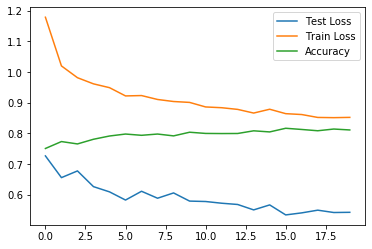

In [12]:
plt.plot(per_epoch_test_loss)
plt.plot(per_epoch_train_loss)
plt.plot([x/100. for x in per_epoch_accuracy])
plt.legend(["Test Loss", "Train Loss", "Accuracy"])
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
# Already did this in the model training.

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
model_path = "C:\\Users\\Vivek\\Udacity\\DeepLearningUsingPyTorch\\CIFAR10_classifier_model.pth"
torch.save(model.state_dict(), model_path)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

In [15]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1660 SUPER', major=7, minor=5, total_memory=6143MB, multi_processor_count=22)

<h2>Recommendation: BUILD</h2>

Since this is an image classification problem with typical (commonly seen) classes, there already are several publicly available pre-trained models as well as public datasets. By utilizing the pretrained feature detection portion of these models, we can quickly replace and retrain just the classifier part of the network to get more than 80% accuracy (81.68% on epoch 15). Given that I was able to throw this together in an afternoon with just a 1660 SUPER, we can certainly get better accuracy by looking at the latest research and experimenting with pre-trained image based models other than the RESNET152 that was used here. 

A few notes:
* Using better hardware such as a local machine with 4 or 8 NVidia 3080 or a cloud setup would help further in iterating more quickly.
* The pre-trained model requires an input of minimum size 224 x 224 which is much bigger than our images (32 x 32), so updating the model input shapes and training from scratch might actually not be too slow.
* Creating a representative subset of the dataset would help speed up experimentation
* The graph indicates that both test and train loss are still dropping so it might be interesting to train longer until the model starts overfitting. However, the rate of improvement has dropped significantly (as expected) so it may not be worth spending more time on it.

<h3>Pre-trained vs self-built model</h3>
Using a pretrained model was very useful in that my GPU only has 6GB of memory and it is very likely that all the weights/biases and gradients of such a large model will probably not fit. Since I'm only retraining a small part that is the classifier, I was able to do it much more quickly.

I also tried training my own model (see below) and was able to get a not that great accuracy of 61.58%. I would probably need to spend some more time improving this model to get anywhere close to the accuracy of the pre-trained network.

Interestingly, the smaller model had higher GPU, CPU as well as disk utilization. While the larger model was around 90% GPU (due to occasional peaks and valleys) and 40% CPU and lower disk use, the smaller model pegged the GPU at 100% with the CPU at 65% and disk at 75%. Perhaps I should have added timing per step to see if the smaller model trains faster and therefore keeps the CPU and disk (dataloader) busy. It is also possible that since I'm retraining only a small part of the larger model, it doesn't have enough compute to keep the GPU at 100%. Might be a good idea to run the NVidia performance analysis tool to validate one of these hypothesis, but any notes from the reviewer would be welcome :)

<H1>Attempt at training my own model (not the pretrained one)</H1>

In [24]:
class CIFARClassifier(nn.Module):
    def __init__(self):
        super(CIFARClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(8)
        
        self.classifier = nn.Sequential(
                                nn.Linear(1800, 450),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(450, 10),
                                nn.LogSoftmax(dim=1)
                          )
        
    def forward(self, images):
        out = self.conv1(images)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.2)
        out = self.classifier(out.view(out.shape[0], -1))
        return out
        
model = CIFARClassifier()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [25]:
from torch.optim import Adam
from torch.nn import NLLLoss

optimizer = Adam(params=model.parameters(), lr=0.001)
# scheduler = MultiStepLR(optimizer, milestones=[1,8], gamma=0.1)
criterion = NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device '{device}'")

Using device 'cuda:0'


In [27]:
EPOCHS = range(20)

per_epoch_train_loss = []
per_epoch_test_loss = []
per_epoch_accuracy = []

for epoch in EPOCHS:
    total_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
        if batch%250 == 0:
            print(f"Epoch {epoch:2} Batch {batch:4} Loss: {loss:.3f} Avg Loss: {total_loss/float(batch+1):.3f}")
            
    per_epoch_train_loss.append(total_loss.item()/float(batch+1)) # Per batch loss
    
    # Compute Test Loss
    with torch.no_grad():
        model.eval()
        
        total_loss = 0
        total_correct = 0
        count = 0
        
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            log_ps = model.forward(images)
            total_loss += criterion(log_ps, labels)
            ps, pred_label = log_ps.topk(1, dim=1)
            
            total_correct += torch.sum(pred_label.view(labels.shape) == labels)
            count += len(labels)
            
        per_epoch_test_loss.append(total_loss.item() / float(batch))
        per_epoch_accuracy.append(100. * total_correct.item() / float(count))
        print(f"Epoch {epoch:2} Train Loss: {per_epoch_train_loss[-1]:.3f} Test Loss: {per_epoch_test_loss[-1]:.3f} Accuracy {per_epoch_accuracy[-1]:.2f}%")
        
        model.train()

Epoch  0 Batch    0 Loss: 2.320 Avg Loss: 2.320
Epoch  0 Batch  250 Loss: 1.611 Avg Loss: 1.859
Epoch  0 Batch  500 Loss: 1.593 Avg Loss: 1.782
Epoch  0 Batch  750 Loss: 1.358 Avg Loss: 1.726
Epoch  0 Batch 1000 Loss: 1.428 Avg Loss: 1.691
Epoch  0 Batch 1250 Loss: 1.261 Avg Loss: 1.663
Epoch  0 Batch 1500 Loss: 1.364 Avg Loss: 1.636
Epoch  0 Train Loss: 1.633 Test Loss: 1.521 Accuracy 46.26%
Epoch  1 Batch    0 Loss: 1.207 Avg Loss: 1.207
Epoch  1 Batch  250 Loss: 1.802 Avg Loss: 1.480
Epoch  1 Batch  500 Loss: 1.194 Avg Loss: 1.458
Epoch  1 Batch  750 Loss: 1.391 Avg Loss: 1.454
Epoch  1 Batch 1000 Loss: 1.444 Avg Loss: 1.446
Epoch  1 Batch 1250 Loss: 1.367 Avg Loss: 1.441
Epoch  1 Batch 1500 Loss: 1.212 Avg Loss: 1.436
Epoch  1 Train Loss: 1.436 Test Loss: 1.337 Accuracy 52.93%
Epoch  2 Batch    0 Loss: 1.276 Avg Loss: 1.276
Epoch  2 Batch  250 Loss: 1.515 Avg Loss: 1.379
Epoch  2 Batch  500 Loss: 1.616 Avg Loss: 1.382
Epoch  2 Batch  750 Loss: 1.361 Avg Loss: 1.379
Epoch  2 Batch 1

Plot the training loss (and validation loss/accuracy, if recorded).

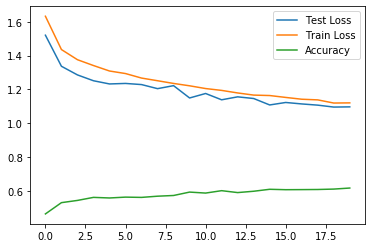

In [28]:
plt.plot(per_epoch_test_loss)
plt.plot(per_epoch_train_loss)
plt.plot([x/100. for x in per_epoch_accuracy])
plt.legend(["Test Loss", "Train Loss", "Accuracy"])
plt.show()